# Finding the perfect model

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nhartman94/TTT-model-building/blob/main/MNIST-shallow-regularization-SOLN.ipynb)

**Goal:** We learned in the lecture a set of tricks for how to build a model that's "just right" for the data!

In this tutorial, we're going to learn how use these training and model building tricks to train a model in pytorch for a toy dataset.

We'll focus on understanding what's happening under the hood to gain intuition for what these "Occom's razor" regularization tricks are doing.

### Table of Contents

1. Data visualization 

- **Q1:** Plot the avg images

2. Model setup

- **Q2:** What's the loss before training (analystical calc)
- **Q3:** What's the loss before training (code check)

3. First training

- **Q4:** Compare with the validation loss

4. Regularization techniques
    - 4a) Batch normalization

        - **Q5:** Visualize the output from the activations in the last step
        - **Q6:** Implement batch norm in your model
        - **Q7:** Compare the activations from the batch normalized model

    - 4b) Dropout
        - **Q8:** Implement dropout in the model

    - 4c) (Bonus) L2 norm
        - **Q9:** Visualize the weights for the models trained earlier
        - **Q10:** Implement the L2 loss

5. Evaluate on the test set

In [9]:
import torch
from torch import nn
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

In [10]:
# %pip install scikit-learn

## 1. Data setup

We're going to use the MNIST dataset as yesterday in Israt's tutorial.

(Caveat: here testing out a smaller one, 8x8 images instead of 28x28)

In [3]:
# https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html

digits = datasets.load_digits()

In [4]:
# digits

In [5]:
X = digits['data']
y = digits["target"]

In [ ]:
# train / val / test (80/20/20) split

# 20% test data
X_tr, X_test, y_tr, y_test = train_test_split(
    torch.FloatTensor(X), torch.LongTensor(y), test_size=0.2
)

# split validation set, 
# 25% of remaining data goes into the validation set

X_tr, X_val, y_tr, y_val = \
    train_test_split(X_tr, y_tr, test_size=0.25)

In [71]:
X_tr.shape

torch.Size([1077, 64])

**Q1** Plot the avg image for each of the classes 

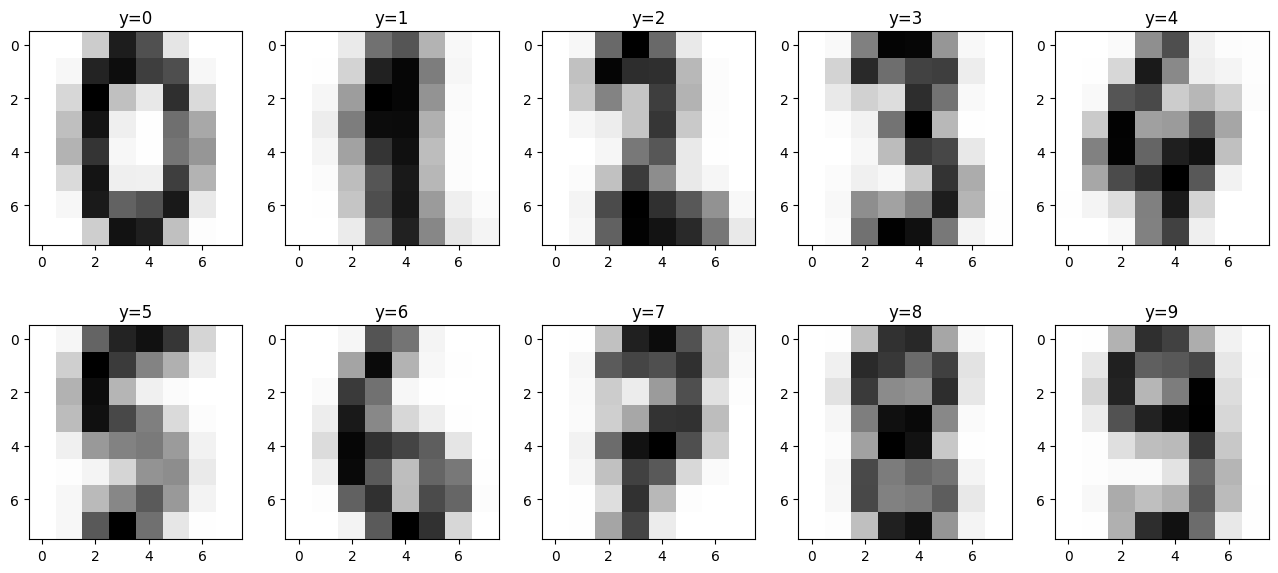

In [11]:
fig, axs = plt.subplots(2,5,figsize=(16,7))

for i,ax in enumerate(axs.flatten()):
    # mean img
    xi =  ... # your code here 
    xi = X_tr[y_tr==i].reshape(-1,8,8).sum(axis=0) # soln
    ax.imshow(xi,cmap='Greys')
    ax.set_title(f'y={i}')


In [12]:
''' 
This function will draw samples from the training batch
'''

N_tr = len(y_tr)
print('# of training evts',N_tr)

def get_train_data(bs=128):

    idx = np.random.choice(N_tr, 128)

    return X_tr[idx], y_tr[idx]


# of training evts 1077


## 2. Model setup

We're at the ERUM deep learning course... so ofc we want to train a NN for classification 😃


In [55]:
# Utility function: count the # of parameters
def count_parameters(model):
    return sum([sum(p.view(-1).shape) for p in model.parameters()])

Below we remind you how to build a model with a single hidden layer and 256 hidden units:

💡 powers of 2

In [17]:
in_dim = 64
out_dim = 10

# Starter code
class myNN(nn.Module):
    """
    We'll keep adding functionality to this NN as we go thru the
    next exercises, but this is the starting skeleton
    """

    def __init__(self, H=64):
        super(myNN, self).__init__()

        # In the init class, need to set the weights of the trainable weights
        self.in_layer = nn.Linear(in_dim, H)
        self.hid_layer = nn.Linear(H, H)
        self.out_layer = nn.Linear(H, out_dim)

    def forward(self, x):
        
        # First linear transformation
        x = self.in_layer(x)
        x = nn.ReLU()(x)

        x = self.hid_layer(x)
        x = nn.ReLU()(x)

        x = self.out_layer(x)

        return x


In [81]:
# Solution code (after working thru the nb)

class myNN(nn.Module):
    """
    We'll keep adding functionality to this NN as we go thru the
    next exercises, but this is the starting skeleton
    """

    def __init__(self, H=64,  batch_norm=False,dropout_prob=0):
        super(myNN, self).__init__()

        
        # In the init class, need to set the weights of the trainable weights
        self.in_layer = nn.Linear(in_dim, H)
        self.hid_layer = nn.Linear(H, H)
        self.out_layer = nn.Linear(H, out_dim)

        self.batch_norm = batch_norm
        self.dropout = dropout_prob >0
        if batch_norm:
            self.bn_layer1 = nn.BatchNorm1d(H)
            self.bn_layer2 = nn.BatchNorm1d(H)

        if self.dropout:
            self.dropout_layer = nn.Dropout(dropout_prob)

    def forward(self, x):
        # First linear transformation
        x = self.in_layer(x)

        if self.batch_norm:
            x = self.bn_layer1(x)

        x = nn.ReLU()(x)
        if self.dropout:
            x = self.dropout_layer(x)

        x = self.hid_layer(x)
        if self.batch_norm:
            x = self.bn_layer2(x)

        x = nn.ReLU()(x)
        if self.dropout:
            x = self.dropout_layer(x)

        x = self.out_layer(x)

        return x


In [23]:
m = myNN(64)

with torch.no_grad():
    out = m(X_tr)
print(out.shape)

torch.Size([1077, 10])


### Loss function: Categorical cross entropy

For targets $y=[0,1, ..., 9]$, our model is outputting $z \in \mathbb{R}^10$, the logits (unnormalized probabilities) for these 10 classes.

We want to interpret the output of the model probabilistically, which we can do via the softmax:

$$\mathrm{Softmax}(z) \rightarrow p_i = \frac{\exp(z_i)}{\sum_{i=1}^K\exp(z_i)}$$

The **cross entropy** loss function is then the negative log likelihood of the training data .

$$
\mathcal{L} = - \frac{1}{N} \sum_i \log p_{y_i},
$$

where $p_{y_i}$ is the predicted probability of the true target class.

**Q2:** What's the loss of this randomly initialized network?

/Users/nicolehartman/miniforge3/envs/nnpdf_env/lib/python3.12/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


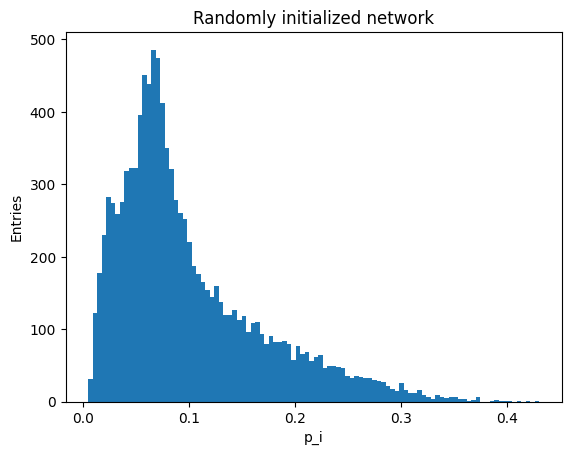

In [25]:
# Warm-up: plot the Softmax prob for the network `m`
# (hint: use nn.Softmax() )


'''
Soln 
'''
plt.hist(nn.Softmax()(out).flatten(),100)
plt.xlabel('p_i')
plt.ylabel('Entries')
plt.title('Randomly initialized network')
plt.show()

<span style="color:blue"> 
Soln:

A randomly init NN has output ~ 1/10 (randomly pred b/w 10 classes, see also plot above). So the expected loss before training is: 

$$- \log 0.1 =\log 10 = 2.3$$
</span>

**Q3:** 💻 Check your calculation, what is the loss for your  model?

**Tip:** You can either code up the loss fct yourself or use `F.cross_entropy`


In [ ]:
# soln Q3
print(F.cross_entropy(out, y_tr))


tensor(2.6900)


## 3. First training

OK... can we improve this loss by training? ⚙️⚙️

Since you trained NNs in the tutorial yday we'll give you some starter code.

In [ ]:
# Soln to Q10 
def get_L2_loss(model):
    # Q10: fill in (later)

    sum_w2=0.
    N = 0
    for p in model.parameters():
        sum_w2 += torch.sum(p**2)
        N += np.prod(p.shape)
    return sum_w2/N 

In [ ]:
# Starter code
def train_model(model, lr=1e-3):

    print(f"training model with {count_parameters(model)} parameters")
    train_losses = []
    val_losses = []

    opt = torch.optim.Adam(model.parameters(), lr)

    for i in range(1000):  # 1k training steps

        model.train()

        xi, yi = get_train_data(128)  # Draw 128 samples
        logits = model(xi)
        loss = nn.CrossEntropyLoss()(logits, yi)

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_losses.append(float(loss))

        # Q4: Calc loss on validation set

        if i % 200 == 0:
            print(float(loss))
    return (model, train_losses, val_losses) 


In [70]:
# Soln code
def train_model(model, lr=1e-3, beta=0):
    """
    To do: Fill in with your new knowledge base how to train a pytorch model

    Inputs:
    - model:
    - lr:
    - beta: for the L2 norm (beta=0 is no L2 norm)
    """

    print(f"training model with {count_parameters(model)} parameters")
    train_losses = []
    val_losses = []

    opt = torch.optim.Adam(model.parameters(), lr)

    for i in range(1000):  # 1k training steps
        model.train()

        xi, yi = get_train_data(128)  # Draw 128 samples
        logits = model(xi)
        loss = nn.CrossEntropyLoss()(logits, yi)

        # soln
        if beta > 0:
            L2 = get_L2_loss(model)
            loss += beta * L2

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_losses.append(float(loss))

        model.eval()
        with torch.no_grad():
            out = model(X_val)
            val_losses.append(nn.CrossEntropyLoss()(out, y_val))

        if i % 200 == 0:
            print(float(loss))
    return (model, train_losses, val_losses)


Train the model and plot the loss

In [56]:
m, tr_loss, val_loss = train_model(m)

training model with 8970 parameters
2.6938633918762207
0.036794234067201614
0.014622621238231659
0.004376090131700039
0.001533272909000516


**Q4:** What about the validation loss?

- [ ] Add the functionality to `train_model`
- [ ] Draw the plot

In [57]:
m.eval()
with torch.no_grad():
    print(f"Val loss: {F.cross_entropy(m(X_val), y_val):.4f}")

Val loss: 0.0818


Text(0, 0.5, 'Loss')

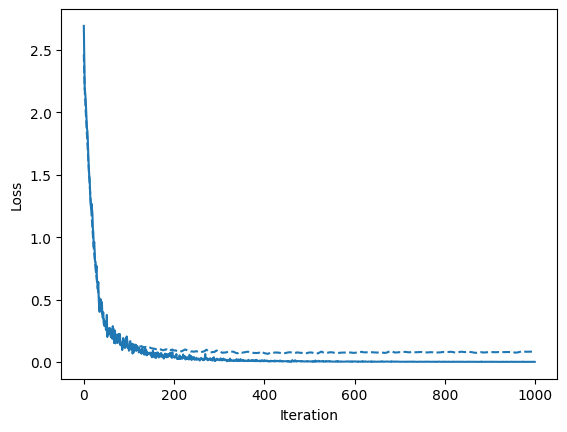

In [65]:
plt.plot(tr_loss,color='C0',label='train')
plt.plot(val_loss,color='C0',label='val',ls='--')
plt.xlabel('Iteration')
plt.ylabel('Loss')

**Q4b:** What do you think? Are we overfitting or underfitting?

## 4. Regularization techniques

### 4a) Batch normalization 

**Q5:** Plot the activations of the hidden units right before the ReLU

(Fun fact, should be 64 b/c this is the size of the hidden latent space!)

**Hint:** For this it will be a lot easier to use the functional API than the sequential one.

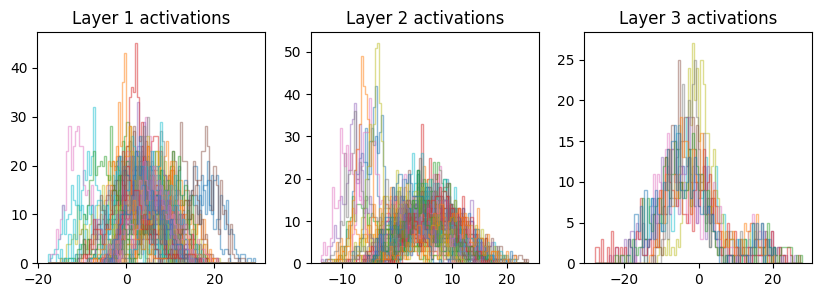

In [75]:
"""
Q5: Plot the activations (on the validation set)

(For inspiration, we show you the first layer)

"""
fig,axs = plt.subplots(1,3,figsize=(10,3))

# Step 1: apply the input xform
with torch.no_grad():
    x = m.in_layer(X_val)  
    # print(x.shape)  

axs[0].hist(x, 100, histtype="step", alpha=0.5)

# Step 2: apply the hidden activations
with torch.no_grad():
    x = nn.ReLU()(x)
    x = m.hid_layer(x)  

axs[1].hist(x, 100, histtype="step", alpha=0.5)

# Step 3: Last output transform
with torch.no_grad():
    x = nn.ReLU()(x)
    x = m.out_layer(x)  

axs[2].hist(x, 100, histtype="step", alpha=0.5)

for i, ax in enumerate(axs):
    ax.set_title(f'Layer {i+1} activations')

plt.show()

<span style="color:blue">  **Main take away:** These outputs are not distribtued around 0 w/ unit variance! </span>

**Q6:** Add batch norm to the model archicture. 
- Tip: `nn.BatchNorm1d`
- Put it right before the ReLU nonlinearity.

Train the new model.

How do the training and validation losses compare?

In [73]:
m_bn = myNN(batch_norm=True)

m_bn, tr_loss_bn, val_loss_bn = train_model(m_bn)


training model with 9226 parameters
2.4326114654541016
0.06437608599662781
0.013464855030179024
0.005150761920958757
0.0030410699546337128


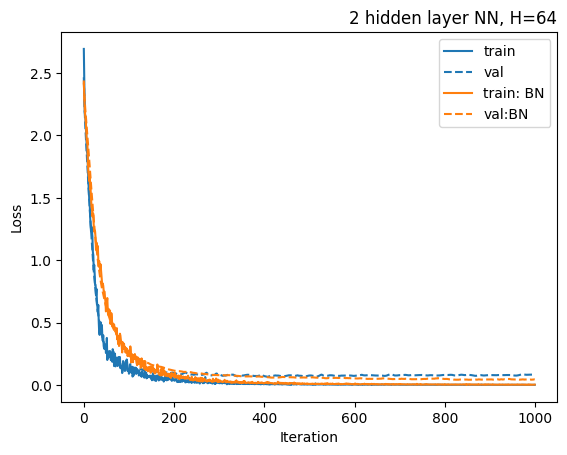

In [77]:
plt.plot(tr_loss, color="C0", label="train")
plt.plot(val_loss, color="C0", label="val", ls="--")

plt.plot(tr_loss_bn, color="C1", label="train: BN")
plt.plot(val_loss_bn, color="C1", label="val:BN", ls="--")

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title('2 hidden layer NN, H=64',loc='right')
plt.legend()

<span style="color:blue">  Yey! It's helping us close the generalization gap :) </span>

**Q7:** Now plot the activations of the model trained with batch norm (a.k.a, plot the model output right after the batch norm layer).

Are they closer to 0 mean, unit variance?

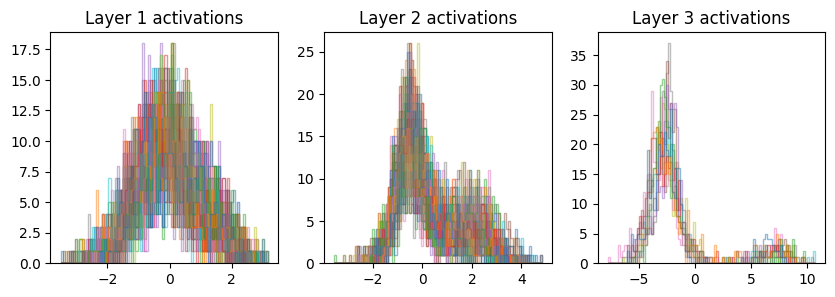

In [80]:
"""
Q7: Revise Q5, but w/ model trained w/ bn
"""

# soln
m_bn.eval()

fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# Step 1: apply the input xform
with torch.no_grad():
    x = m_bn.in_layer(X_val)
    x = m_bn.bn_layer1(x)
    

axs[0].hist(x, 100, histtype="step", alpha=0.5)

# Step 2: apply the hidden activations
with torch.no_grad():
    
    x = nn.ReLU()(x)
    x = m_bn.hid_layer(x)
    x = m_bn.bn_layer2(x)

axs[1].hist(x, 100, histtype="step", alpha=0.5)

# Step 3: Last output transform
with torch.no_grad():
    
    x = nn.ReLU()(x)
    x = m_bn.out_layer(x)

axs[2].hist(x, 100, histtype="step", alpha=0.5)

for i, ax in enumerate(axs):
    ax.set_title(f"Layer {i + 1} activations")

plt.show()


<span style="color:blue">  Yes!The activations are getting more regular. 
There's no batch norm applied at the final layer b/c this is an `argmax` operation for finding the right logit.

 </span>

### 4b) Dropout

**Q8:** Add dropout to the model and compare trainings.

Where to put it? put it after the ReLU nonlinearities.

In [91]:
# Soln

p=0.1 # dropout fraction

m_dpt = myNN(dropout_prob=p)
m_dpt, tr_loss_dpt, val_loss_dpt = train_model(m_dpt)


m_bn_dpt = myNN(batch_norm=True,dropout_prob=p)
m_bn_dpt, tr_loss_bn_dpt, val_loss_bn_dpt = train_model(m_bn_dpt)


training model with 8970 parameters
2.8446202278137207
0.08997203409671783
0.06797010451555252
0.03545849770307541
0.021600298583507538
training model with 9226 parameters
2.4266653060913086
0.11341434717178345
0.04085830599069595
0.014744026586413383
0.008144310675561428


(0.0, 0.5)

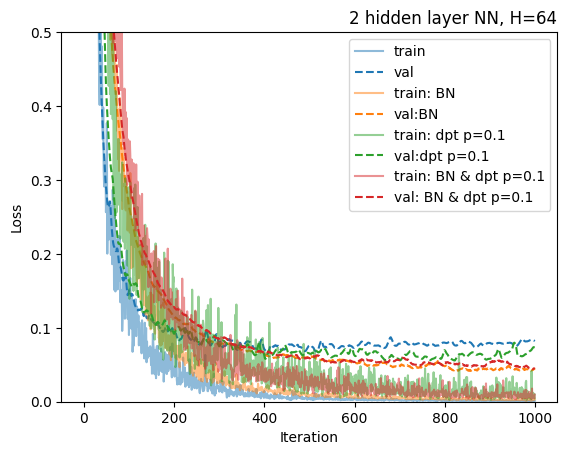

In [92]:
plt.plot(tr_loss, color="C0", label="train",alpha=.5)
plt.plot(val_loss, color="C0", label="val", ls="--")

plt.plot(tr_loss_bn, color="C1", label="train: BN",alpha=.5)
plt.plot(val_loss_bn, color="C1", label="val:BN", ls="--")

plt.plot(tr_loss_dpt, color="C2", label=f"train: dpt p={p}",alpha=.5)
plt.plot(val_loss_dpt, color="C2", label=f"val:dpt p={p}", ls="--")

plt.plot(tr_loss_bn_dpt, color="C3", label=f"train: BN & dpt p={p}", alpha=0.5)
plt.plot(val_loss_bn_dpt, color="C3", label=f"val: BN & dpt p={p}", ls="--")


plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("2 hidden layer NN, H=64", loc="right")
plt.legend()
plt.ylim(0,.5)

<span style="color:blue">  For these experiments, looks like bn is helping... somewhat altho it does depend on the random seed for the training.
 </span>

### 4c) (Bonus) L2 normalization

**Q9:** Visualize the weights for our trained models

In [ ]:
# Tip: To get the weight and bias of the first layer..
print('W',m.in_layer.weight)
print("b", m.in_layer.bias)

W Parameter containing:
tensor([[-9.9104e-02,  1.0338e-01,  6.1692e-02,  ..., -1.2344e-01,
          1.0169e-01,  3.0574e-02],
        [ 5.9302e-02,  1.0096e-02, -4.6248e-02,  ..., -1.2212e-01,
          1.6512e-01,  3.8644e-02],
        [-6.5180e-02, -3.4859e-02,  6.2345e-02,  ...,  4.6764e-05,
         -9.4876e-02,  1.1603e-01],
        ...,
        [ 3.2528e-02,  7.3746e-02,  2.0938e-01,  ...,  1.5270e-02,
         -5.2876e-02, -3.2496e-02],
        [ 3.4435e-02,  4.3943e-02, -5.5226e-02,  ...,  1.2606e-01,
         -6.3723e-02, -1.0637e-01],
        [-1.2056e-01, -1.2894e-01,  1.4191e-02,  ..., -7.0411e-02,
          1.5870e-01,  1.9847e-01]], requires_grad=True)
b Parameter containing:
tensor([ 0.1698,  0.0358, -0.1382, -0.0210, -0.0573,  0.0220,  0.0081, -0.0676,
        -0.0840, -0.0258, -0.0124,  0.0879,  0.1038,  0.0940,  0.0667,  0.1191,
         0.0842,  0.0155, -0.0216, -0.0190, -0.1084,  0.0253,  0.1046,  0.0206,
        -0.0666, -0.0445, -0.1033,  0.0200, -0.0546,  0.0267

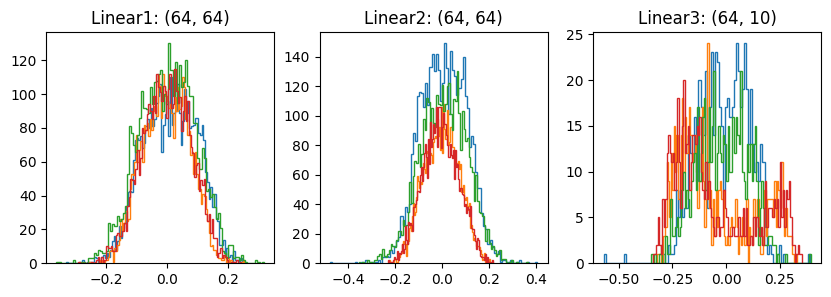

In [96]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# input layer
for mi in [m, m_bn, m_dpt, m_bn_dpt]:

    for i,layer, ax in zip(range(3),[mi.in_layer, mi.hid_layer, mi.out_layer],axs.flatten()):

        wi = layer.weight.detach()
        bi = layer.bias.detach()

        ax.hist(np.hstack([wi.flatten(), bi.flatten()]), 100, histtype="step")
        ax.set_title(f"Linear{i+1}: {wi.numpy().T.shape}")



<span style="color:blue">  Cute that batch norm is also helping encourage some of these weights to be close to 0 </span>

**Q10:** Implement the L2 loss and compare...

Question for you... _where_ and how will you implement the L2 loss?


In [101]:
m_l2 = myNN()

m_l2, tr_loss_l2, val_loss_l2 = train_model(m_l2, 1e-3, beta=1e-3)


training model with 8970 parameters
2.494974374771118
0.033672597259283066
0.006735167931765318
0.002957593882456422
0.002193852560594678


(0.0, 0.5)

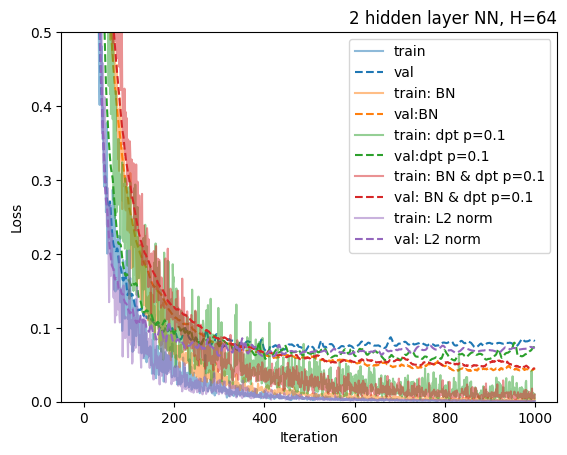

In [102]:
plt.plot(tr_loss, color="C0", label="train", alpha=0.5)
plt.plot(val_loss, color="C0", label="val", ls="--")

plt.plot(tr_loss_bn, color="C1", label="train: BN", alpha=0.5)
plt.plot(val_loss_bn, color="C1", label="val:BN", ls="--")

plt.plot(tr_loss_dpt, color="C2", label=f"train: dpt p={p}", alpha=0.5)
plt.plot(val_loss_dpt, color="C2", label=f"val:dpt p={p}", ls="--")

plt.plot(tr_loss_bn_dpt, color="C3", label=f"train: BN & dpt p={p}", alpha=0.5)
plt.plot(val_loss_bn_dpt, color="C3", label=f"val: BN & dpt p={p}", ls="--")


plt.plot(tr_loss_l2, color="C4", label=f"train: L2 norm", alpha=0.5)
plt.plot(val_loss_l2, color="C4", label=f"val: L2 norm", ls="--")


plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("2 hidden layer NN, H=64", loc="right")
plt.legend()
plt.ylim(0, 0.5)


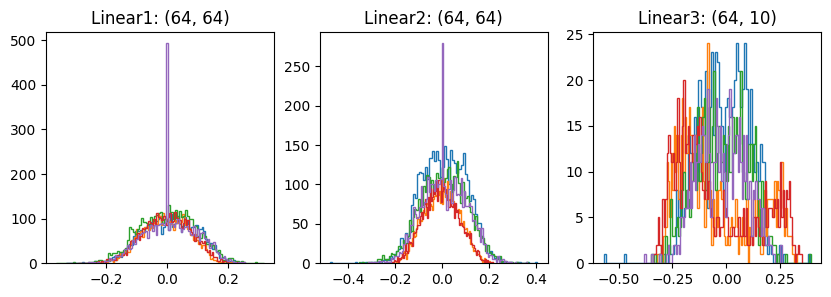

In [103]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# input layer
for mi in [m, m_bn, m_dpt, m_bn_dpt, m_l2]:
    for i, layer, ax in zip(
        range(3), [mi.in_layer, mi.hid_layer, mi.out_layer], axs.flatten()
    ):
        wi = layer.weight.detach()
        bi = layer.bias.detach()

        ax.hist(np.hstack([wi.flatten(), bi.flatten()]), 100, histtype="step")
        ax.set_title(f"Linear{i + 1}: {wi.numpy().T.shape}")


<span style="color:blue"> OK, the loss (compared to blue) does get marginally better, and cute that we can also see in the purple weights some more of the weights getting pulled to 0 w/ the L2 loss. <\span>

## 5. Evaluate on the test set

Now that you're done w/ the optimizations on the val set... how did we do on the test set?

In [104]:
# Fill in after you're done w/ any final optimizations you want to do!

## Final thoughts

Great job! We've been diving into some of the guts of NNs and classic training techniques.

Something you might have notices is your experiments are a bit noisy, e.g, rerunning w/ the a new random seed can produce different results.

For a more robust study, we'd repeat each experiment 5-10 times and report the mean and error bar (the "deep ensembles error" that we discussed in lecture)... but the point here was just to get some hands-on-keyboard understanding of the concepts we were covering.

Until next time... happy training 🌞 🚊